In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
import missingno as msno
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df_train = pd.read_csv('data/train.csv')
pd.set_option('display.max_columns', len(df_train.columns))
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
num_var = list(df_train._get_numeric_data().columns)
cat_var = list(set(df_train.columns) - set(num_var))

In [4]:
# pourcentage of unique values for categorical variables
df_train[num_var].nunique().sort_values(ascending=False).head(10)

Id             1460
LotArea        1073
GrLivArea       861
BsmtUnfSF       780
1stFlrSF        753
TotalBsmtSF     721
SalePrice       663
BsmtFinSF1      637
GarageArea      441
2ndFlrSF        417
dtype: int64

In [5]:
# pourcentage of unique values for categorical variables
df_train[cat_var].nunique().sort_values(ascending=False).head(10)

Neighborhood    25
Exterior2nd     16
Exterior1st     15
SaleType         9
Condition1       9
HouseStyle       8
Condition2       8
RoofMatl         8
Functional       7
Foundation       6
dtype: int64

<AxesSubplot:>

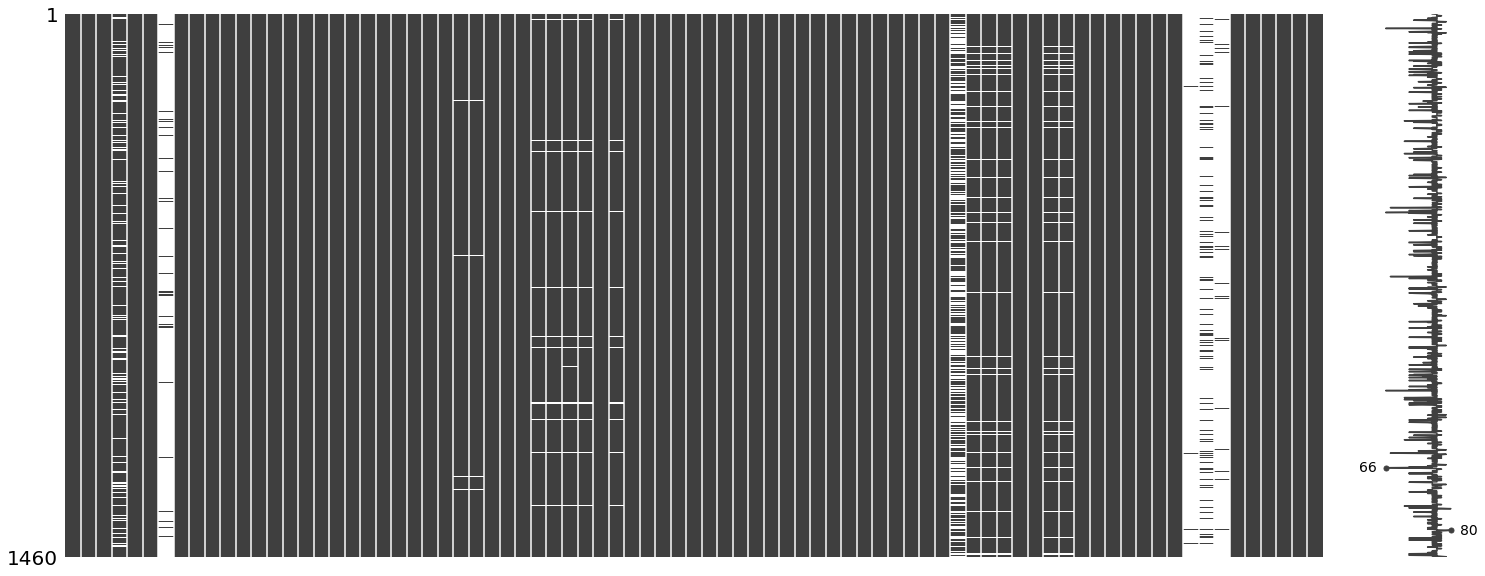

In [6]:
msno.matrix(df_train)

In [7]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [8]:
# drop columns because too many NaN values
to_remove = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
df_train = df_train.drop(to_remove, axis=1)
cat_var = list(set(cat_var) - set(to_remove))

In [9]:
# drop remaining row containing NaN values
df_train = df_train.dropna()

In [10]:
df_train[num_var].head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


In [11]:
df_train = df_train.drop(['Id'], axis=1)
num_var.remove('Id')

In [12]:
df_train[cat_var].head()

,HeatingQC,HouseStyle,MSZoning,BsmtFinType1,Electrical,RoofStyle,GarageQual,GarageCond,Utilities,LandSlope,BsmtQual,Exterior2nd,RoofMatl,Condition2,GarageType,LandContour,Street,PavedDrive,Foundation,Heating,Condition1,CentralAir,MasVnrType,LotConfig,ExterQual,KitchenQual,BsmtCond,Exterior1st,Neighborhood,BldgType,LotShape,GarageFinish,SaleCondition,Functional,SaleType,ExterCond,BsmtFinType2,BsmtExposure
0,Ex,2Story,RL,GLQ,SBrkr,Gable,TA,TA,AllPub,Gtl,Gd,VinylSd,CompShg,Norm,Attchd,Lvl,Pave,Y,PConc,GasA,Norm,Y,BrkFace,Inside,Gd,Gd,TA,VinylSd,CollgCr,1Fam,Reg,RFn,Normal,Typ,WD,TA,Unf,No
1,Ex,1Story,RL,ALQ,SBrkr,Gable,TA,TA,AllPub,Gtl,Gd,MetalSd,CompShg,Norm,Attchd,Lvl,Pave,Y,CBlock,GasA,Feedr,Y,None,FR2,TA,TA,TA,MetalSd,Veenker,1Fam,Reg,RFn,Normal,Typ,WD,TA,Unf,Gd
2,Ex,2Story,RL,GLQ,SBrkr,Gable,TA,TA,AllPub,Gtl,Gd,VinylSd,CompShg,Norm,Attchd,Lvl,Pave,Y,PConc,GasA,Norm,Y,BrkFace,Inside,Gd,Gd,TA,VinylSd,CollgCr,1Fam,IR1,RFn,Normal,Typ,WD,TA,Unf,Mn
3,Gd,2Story,RL,ALQ,SBrkr,Gable,TA,TA,AllPub,Gtl,TA,Wd Shng,CompShg,Norm,Detchd,Lvl,Pave,Y,BrkTil,GasA,Norm,Y,None,Corner,TA,Gd,Gd,Wd Sdng,Crawfor,1Fam,IR1,Unf,Abnorml,Typ,WD,TA,Unf,No
4,Ex,2Story,RL,GLQ,SBrkr,Gable,TA,TA,AllPub,Gtl,Gd,VinylSd,CompShg,Norm,Attchd,Lvl,Pave,Y,PConc,GasA,Norm,Y,BrkFace,FR2,Gd,Gd,TA,VinylSd,NoRidge,1Fam,IR1,RFn,Normal,Typ,WD,TA,Unf,Av


In [13]:
# first analyse the target variable
df_train['SalePrice'].describe()

count      1094.000000
mean     187033.263254
std       83165.332151
min       35311.000000
25%      132500.000000
50%      165750.000000
75%      221000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:>

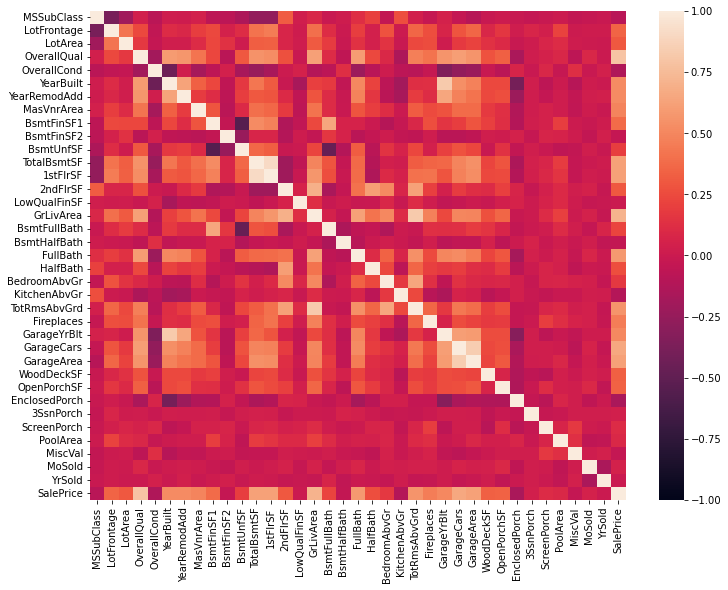

In [14]:
corr_mat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmax=1, vmin=-1)

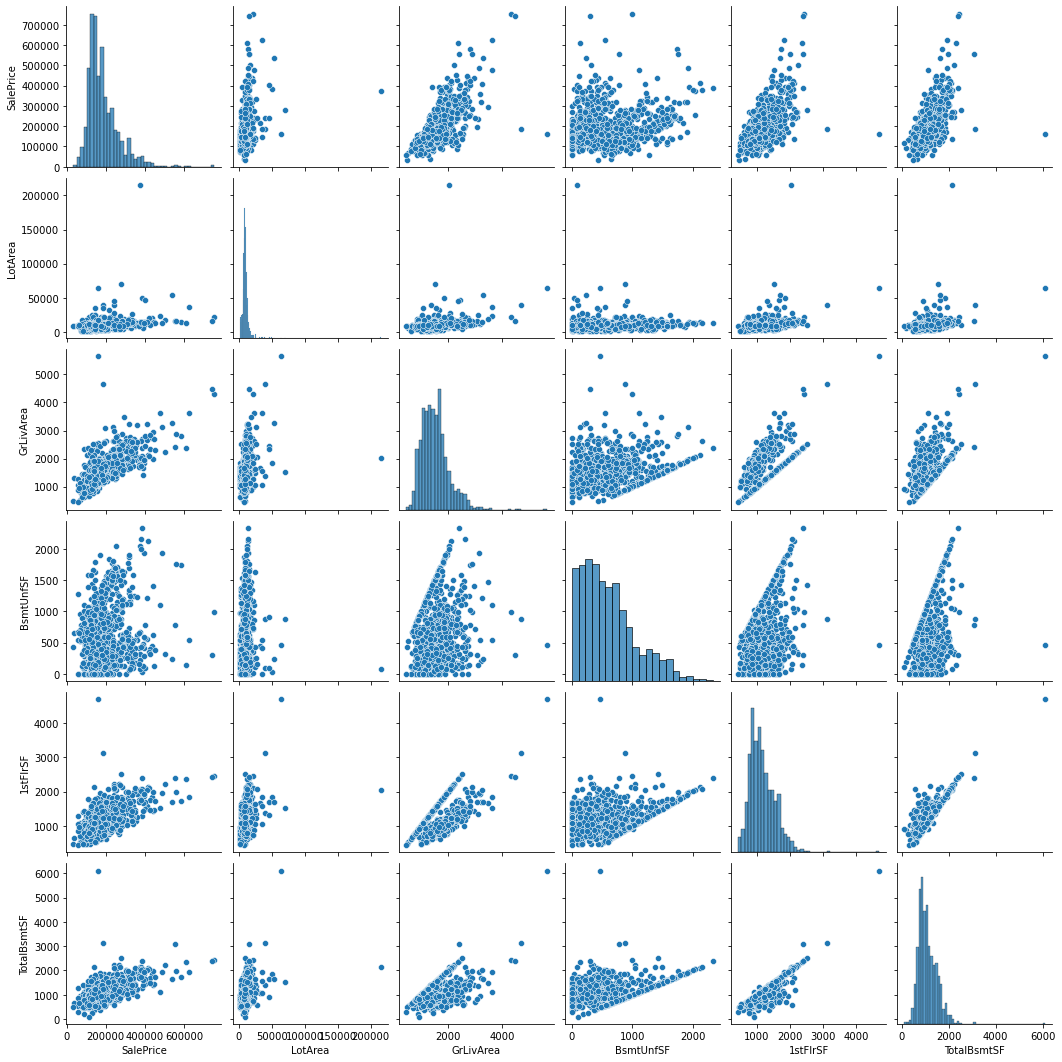

In [15]:
sns.pairplot(df_train[['SalePrice', 'LotArea', 'GrLivArea', 'BsmtUnfSF', '1stFlrSF', 'TotalBsmtSF']])

In [ ]:
# DETECT AND REMOVE OUTLIERS